## Tumor Segmentation with U-Net Networks

### Imports

A few imports needed to run this notebook

In [1]:
# Common Python imports
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import tqdm.notebook as tqdm

# Torch imports
import torch as th

# Typining hints
from typing import List, Union, Callable

# Change cwd to the parent directory and add it to the Python path
os.chdir("/home/marco/deep-learning-project/")
sys.path.append(os.getcwd())
print(f"Current working directory: 📂 {os.getcwd()}")

# Set the default style
sns.set_theme(
	style="whitegrid",
	palette="tab10",
	rc={
		"grid.linestyle": "--",
		"grid.color": "gray",
		"grid.alpha": 0.5,
	},
)

# Model import
from models.classic_unet import ClassicUNet
from models.improved_unet import ImprovedUNet
from models.attention_unet import AttentionUNet, VisualAttentionUNet

# Dataset loader
from utils.datasets import load_segmentation, load_single

# Utils imports
from utils.analysis import *
from utils.metrics import *
from utils.train import *

Current working directory: 📂 /home/marco/deep-learning-project


### Hyperparameters

Here we set the models hyperparameters.

<span style="color:yellow;">⚠ **Warning**: Notice that these hyperparameters must be the same ones used to obtain the models weights during the training phase with the [`unet_training.py`](../training/unet_training.py) script since in this notebook we are **loading** the weights.</span>

Accordingly we have to choose the correct folder in which the weights and the relative metrics are stored.

In [2]:
# Training hyperparameters
PERCENTAGE: float   = 0.5
SPLIT: float        = 0.9
N_FILTERS: int      = 32
IMG_SIZE: int       = 240
EPOCHS: int         = 20
BATCH_TRAIN: int    = 32
BATCH_VALID: int    = 32
LR: float           = 2e-3
WEIGHT_DECAY: float = 1e-2
GAMMA: float        = 0.9


# Loss function
CRITERION: Union[th.nn.Module, Callable[[th.Tensor, th.Tensor], th.Tensor]] = (
	th.nn.BCEWithLogitsLoss()
)


# Dataset, Models and Metrics folders
DATASETS: str = "datasets"
SEGMENTATION: str = os.path.join(DATASETS, "segmentation/data")
SAVE_MODELS_PATH: str = f"models/saved_models"
SAVE_METRICS_PATH: str = f"models/saved_metrics"


# Device setup
device: th.device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(f"Using device: 💻 {device}")

Using device: 💻 cpu


### Dataset

We can now load the dataset with the dedicated functions. These have a deterministic behaviour if selected so the dataset composition will be the same used during training.

In [3]:
# Load the dataset
train_dataloader, valid_dataloader = load_segmentation(
	directory=SEGMENTATION,
	split=SPLIT,
	train_batch_size=BATCH_TRAIN,
	valid_batch_size=BATCH_VALID,
	percentage=PERCENTAGE,
	resize=(IMG_SIZE, IMG_SIZE),
	deterministic=True,
)

# Count examples in the dataset
print(f"Total examples:      {len(train_dataloader.dataset) + len(valid_dataloader.dataset)} examples")
print(f"Train-Test split:    {SPLIT*100:.0f}% - {(1-SPLIT)*100:.0f}%")
print(f"Train-Test examples: {len(train_dataloader.dataset)} - {len(valid_dataloader.dataset)}")

# Verify image sizes
for images, masks in train_dataloader:
	print("Training batch   - Images shape:", images.shape, "Masks shape:", masks.shape)
	break
for images, masks in valid_dataloader:
	print("Validation batch - Images shape:", images.shape, "Masks shape:", masks.shape)
	break

Total examples:      28413 examples
Train-Test split:    90% - 10%
Train-Test examples: 25571 - 2842
Training batch   - Images shape: torch.Size([32, 4, 240, 240]) Masks shape: torch.Size([32, 3, 240, 240])
Validation batch - Images shape: torch.Size([32, 4, 240, 240]) Masks shape: torch.Size([32, 3, 240, 240])


We can then plot a single image and its relative mask to check if the dataset is loaded correctly.

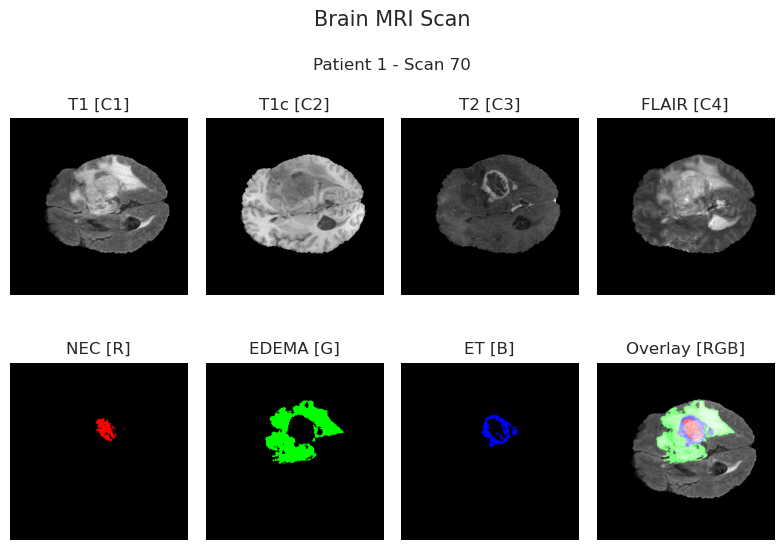

In [4]:
# Patient's index (between 1 and 369)
index: int = 1

# Scan index (between 0 and 155)
scan: int = 70

# Load the patient's scans
images, masks = load_single(directory=SEGMENTATION, index=index, resize=(IMG_SIZE, IMG_SIZE))

# Plot the patient's scans
display_scan(scan, index, images, masks)

The following insteada will produce an animated GIF with all the scans for a given patient.

⌚ **Note**: This may take a while to run...

In [5]:
# # Patient index
# index: int = 1

# # Animated gif of the scans (might take a while to generate)
# output_gif = display_animated(patient_index=index,
#                               images=images, 
#                               masks=masks, 
#                               output_file=f'images/patient_scans_{index}.gif', scan_range=range(len(images)))
# display(output_gif)

### U-Net Models

We can now define and load the trained model for the segmentation task.

In [6]:
# Select and initialize the U-Net models
# classic_model: th.nn.Module = ClassicUNet(n_filters=N_FILTERS)
# improved_model: th.nn.Module = ImprovedUNet(n_filters=N_FILTERS)
attention_model: th.nn.Module = AttentionUNet(n_filters=N_FILTERS)
visual_model: th.nn.Module = VisualAttentionUNet(n_filters=N_FILTERS) # Just for visualization

# Move the models to the device
# classic_model.to(device)
# improved_model.to(device)
attention_model.to(device)
visual_model.to(device)

# Count the total number of parameters
# classic_total_params = count_parameters(classic_model)
# improved_total_params = count_parameters(improved_model)
attention_total_params = count_parameters(attention_model)
# print(f"Classic U-Net total parameters:   {classic_total_params}")
# print(f"Improved U-Net total parameters:  {improved_total_params}")
print(f"Attention U-Net total parameters: {attention_total_params}")

# Load the models from the last training epoch

# File names
# classic_name: str = os.path.join(SAVE_MODELS_PATH, f"{classic_model.name}_e{EPOCHS}.pth")
# improved_name: str = os.path.join(SAVE_MODELS_PATH, f"{improved_model.name}_e{EPOCHS}.pth")
attention_name: str = os.path.join(SAVE_MODELS_PATH, f"{attention_model.name}_e{EPOCHS}.pth")

# Loading location
map_location = th.device('cuda') if th.cuda.is_available() else th.device('cpu')

# Training checkpoints
# classic_checkpoint = th.load(classic_name, map_location=map_location)
# improved_checkpoint = th.load(improved_name, map_location=map_location)
attention_checkpoint = th.load(attention_name, map_location=map_location)

# Load the models
# classic_model.load_state_dict(classic_checkpoint["model_state_dict"])
# improved_model.load_state_dict(improved_checkpoint["model_state_dict"])
attention_model.load_state_dict(attention_checkpoint["model_state_dict"])
visual_model.load_state_dict(attention_checkpoint["model_state_dict"])

Attention U-Net total parameters: 3258263


/tmp/ipykernel_119395/2750094784.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  attention_checkpoint = th.load(attention_name, map_location=map_location)


<All keys matched successfully>

With the models trained we can for example see how a single prediction from one of these models looks like.

In [7]:
# # Get an image from the validation dataset that the model hasn't been trained on
# test_image, test_mask = next(iter(valid_dataloader))
# index: int = np.random.randint(0, BATCH_VALID)

# # Add batch dimension to the test image
# test_image = test_image[index].unsqueeze(0)
# test_mask = test_mask[index].unsqueeze(0)

# # Get prediction and true mask
# prediction = classic_model(test_image.to(device))
# mask = test_mask.to(device)

# # Compute metrics
# dice_coeff = dice(prediction, mask)
# iou_coeff = IoU(prediction, mask)
# accuracy = accuracy2D(prediction, mask)
# fpr = fpr2D(prediction, mask)
# fnr = fnr2D(prediction, mask)
# precision = precision2D(prediction, mask)
# recall = recall2D(prediction, mask)

# # Convert metrics to percentage format
# dice_coeff = [score * 100 for score in dice_coeff]
# iou_coeff = [score * 100 for score in iou_coeff]
# accuracy = [score * 100 for score in accuracy]
# fpr = [score * 100 for score in fpr]
# fnr = [score * 100 for score in fnr]
# precision = [score * 100 for score in precision]
# recall = [score * 100 for score in recall]

# # Create a DataFrame to display the metrics
# metrics = {
# 	'Dice': dice_coeff,
# 	'IoU': iou_coeff,
# 	'Accuracy': accuracy,
# 	'FPR': fpr,
# 	'FNR': fnr,
# 	'Precision': precision,
# 	'Recall': recall,
# }
# rows = ['Red', 'Green', 'Blue', 'Average']
# df = pd.DataFrame(metrics, index=rows)
# pd.options.display.float_format = '{:.2f}'.format

# print("Performance metrics (%)")
# print("-----------------------------------------------------------")
# print(df)

# # Display the prediction
# display_prediction(classic_model, test_image, test_mask, device=device)

### Performance Assessment Metrics

We now display the metrics used for assessing the models performance. These are shown both for the training and validation sets. Moreover we show both the final metrics reached as well as their evolution through the epochs.\
First of all we need to load the saved dataframes containing the metrics.

In [7]:
# classic_df = pd.read_csv(os.path.join(SAVE_METRICS_PATH, f"metrics_{classic_model.name}.csv"))
# improved_df = pd.read_csv(os.path.join(SAVE_METRICS_PATH, f"metrics_{improved_model.name}.csv"))
attention_df = pd.read_csv(os.path.join(SAVE_METRICS_PATH, f"metrics_{attention_model.name}.csv"))

Then we can plot the final metrics for the training and the validation sets.

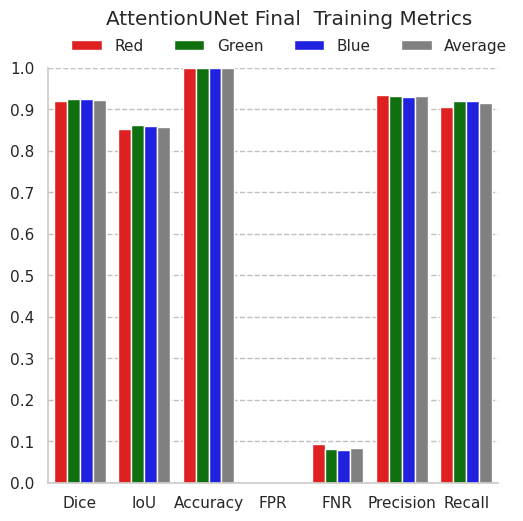

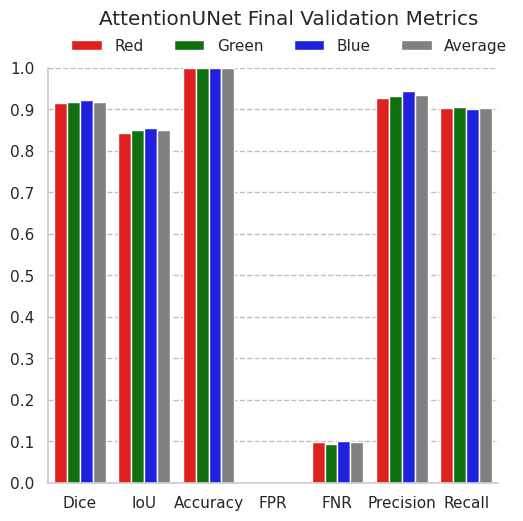

In [9]:
# barplot_metrics_multiple([classic_df, improved_df, attention_df], [classic_model, improved_model, attention_model])
barplot_metrics(attention_df, attention_model, "train")
barplot_metrics(attention_df, attention_model, "valid")

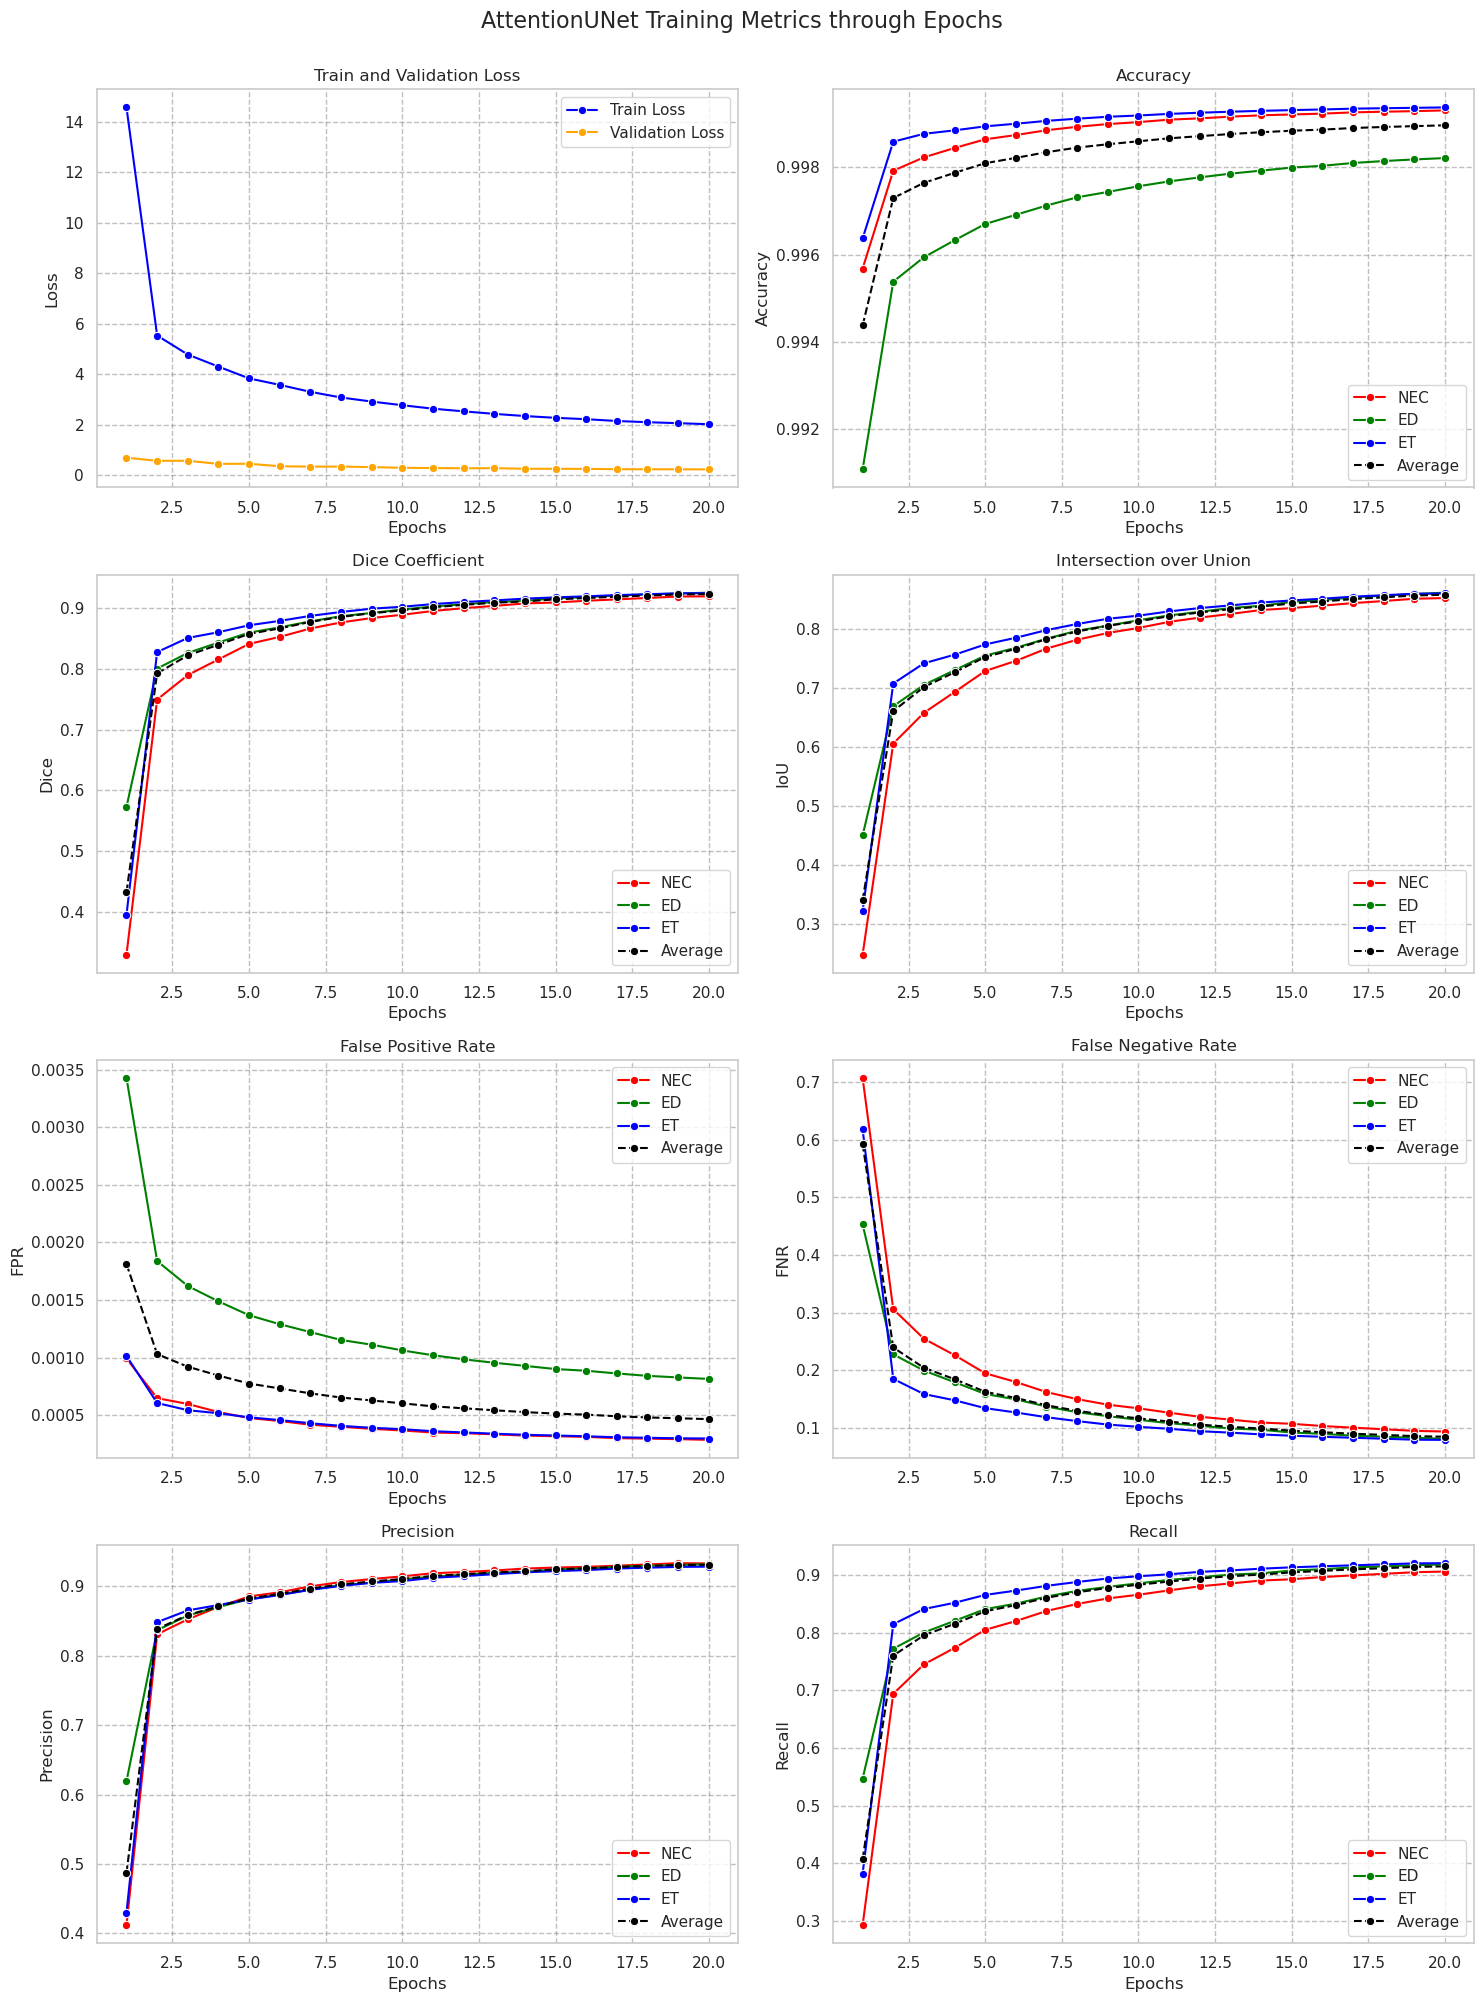

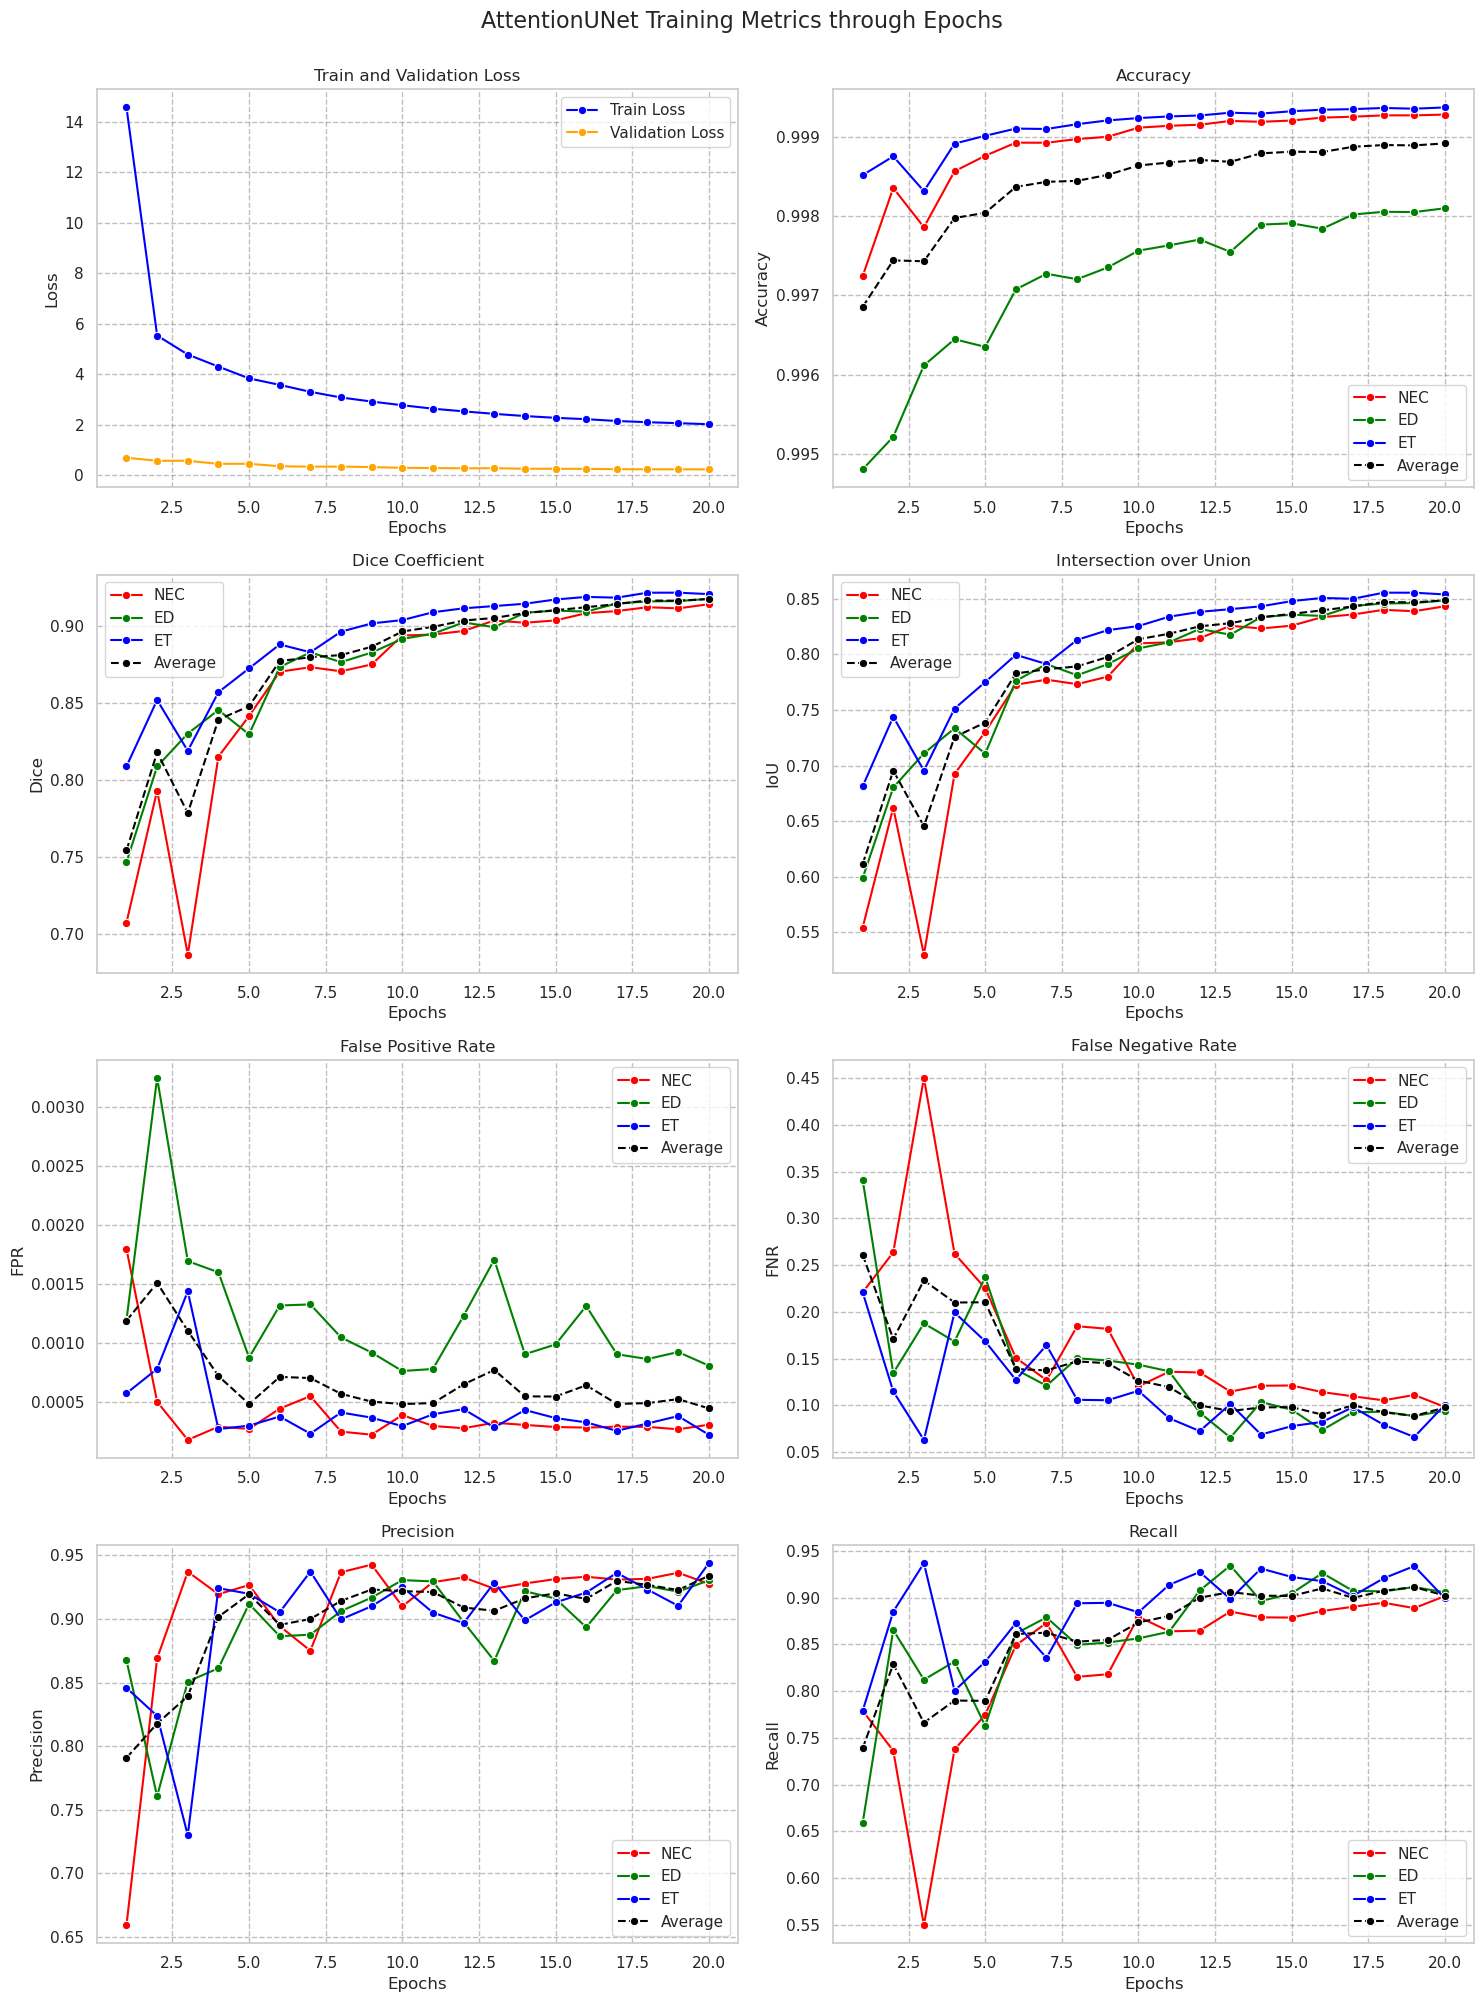

In [10]:
# Plot metrics vs epochs
# plot_metrics(classic_df, classic_model)
# plot_metrics(improved_df, improved_model)
plot_metrics(attention_df, attention_model, "train")
plot_metrics(attention_df, attention_model, "valid")

### Visualize Attention Blocks

Finally, we can actually visualize the attention blocks of the Attention U-Net model for any given image in the dataset. This will show the attention maps used in the 4 updampling operations. The lower the attention map number the more abstract is the representation of the input images.

map_4 shape: torch.Size([1, 1, 15, 15])
map_3 shape: torch.Size([1, 1, 30, 30])
map_2 shape: torch.Size([1, 1, 60, 60])
map_1 shape: torch.Size([1, 1, 120, 120])


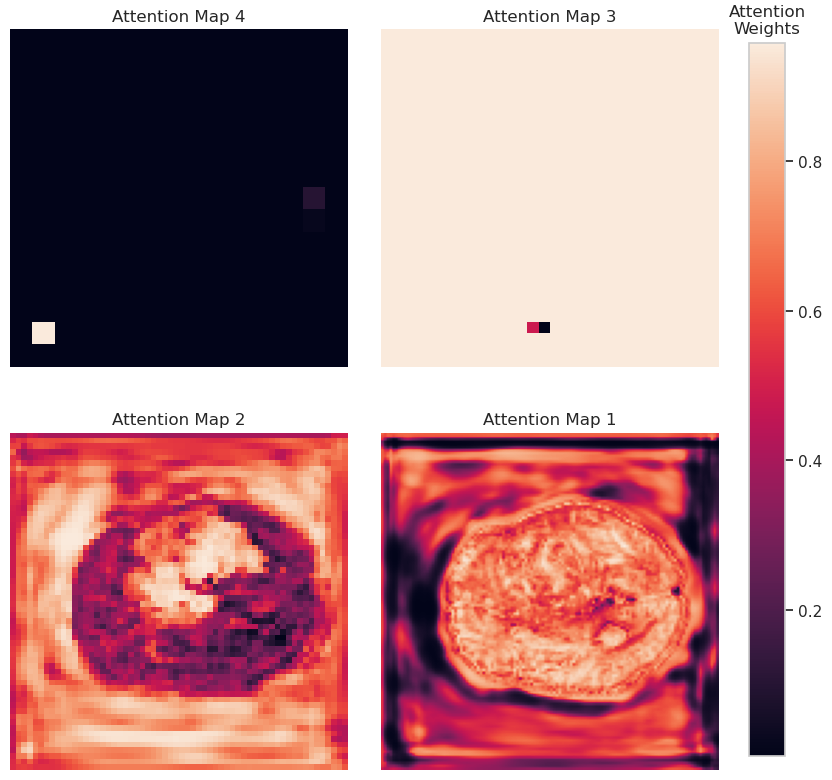

In [46]:
# Patient's index


index: int = 1

# Scan index
scan: int = 70

# Load the patient's scans
images, masks = load_single(directory=SEGMENTATION, index=index, resize=(IMG_SIZE, IMG_SIZE))
image = images[scan].unsqueeze(0)
mask = masks[scan].unsqueeze(0)

# Get the attention maps from the modified model
_, map_1, map_2, map_3, map_4 = visual_model(image.to(device))

# Print shapes of attention maps
print(f'map_4 shape: {map_4.shape}')
print(f'map_3 shape: {map_3.shape}')
print(f'map_2 shape: {map_2.shape}')
print(f'map_1 shape: {map_1.shape}')

# display_image_channels(images[scan])
# display_mask_channels(masks[scan])

# Plot the 4 attention maps
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.1, hspace=0.1)

# Create subplots
axes = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(2)]

# Plot each attention map
for idx, (ax, att_map) in enumerate(zip(axes, [map_4, map_3, map_2, map_1])):
    att_map = att_map.detach().cpu().numpy().squeeze()
    im = ax.imshow(att_map, cmap='rocket')
    ax.set_title(f'Attention Map {4-idx}')
    ax.axis('off')
    ax.grid(False)

# Add a color bar
cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Attention\nWeights', rotation=0, labelpad=-40, y=1.055)

plt.show()